# PCA

In this assignment we have to fullfill the following tasks:

Create labeled surrogate data sets. Perform a PCA/Class prediction with ovr logistic regression analysis as developed in the lecture.

* **a:** 4 blobs: Create clearly separable 4-blobs in 3d but also a ’disaster’ realization with strong overlaps. Study, show and compare elbow plots and prediction boundaries.

* **b:** 2 touching parabola spreads as shown in the lecture, but in 3d (not 2d). Study and show elbow plot and prediction boundaries.

**Note:** Every plot must be followed by a small take home message.

In [1]:
### imports ###
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

<div class="alert alert-block alert-info">
<b>Note:</b> In order to present the different changes, if we go from clearly separable to unclear and unseparable, we will use the prefix <i>cs_</i> for clearly separable and <i>uc_</i> for unclear separable.
</div>

In [2]:
class Blobs_and_parabolas():
    
    def __init__(self, n_samples = 250, n_features = 13, centers = 4, cluster_std = 1, center_box =(-50,50),
                blob = None, parabola = None):
        if blob:
            self.X, self.y = make_blobs(n_samples = n_samples,
                                        n_features = n_features,
                                        centers = centers,
                                        cluster_std = cluster_std,
                                        center_box = center_box)
        elif parabola:
            self.X, self.y = make_moons(n_samples = 10000)
            self.X = np.column_stack((self.X, np.random.choice(self.X[:,1], (len(self.X),n_features))))
            self.idx = self.y == 1
        else:
            assert("Please select either blob = True or parabola = True")
            
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
                                self.X, self.y, test_size=0.3, stratify=self.y, random_state=0)
        # Standardize the features (zero mean, unit variance) 
        self.sc = StandardScaler()
        # Fit results must be used later (mu and sigma)
        self.X_train_std = self.sc.fit_transform(self.X_train)
        # Normalize test data set with mu/sigma of training data
        self.X_test_std = self.sc.transform(self.X_test)
        self.cov_mat = np.cov(self.X_train_std.T) #cov matrix from data
        self.EVal, self.EVec = np.linalg.eig(self.cov_mat)
        self.sum_EVal = sum(self.EVal)
        self.var_exp = [(i / self.sum_EVal) for i in sorted(self.EVal, reverse=True)]
        
    def _pca_and_lr(self, n_components = 2):
        # Set up PCA and logistic regression model
        self.pca = PCA(n_components= n_components)
        self.lr = LogisticRegression(multi_class='ovr', solver='liblinear')

        # Fit and transform training data, given on PCA reduction to k(=2) principle components
        self.X_train_pca = self.pca.fit_transform(self.X_train_std)
        self.X_test_pca = self.pca.transform(self.X_test_std)
        # solves task, given 3 classes (as from y_train) 
        self.lr.fit(self.X_train_pca, self.y_train)
        
    def plot_decision_regions(self, resolution=0.01, subplot = False):
        self._pca_and_lr()
        # Does not work....always....Setup marker generator and color map: FIXED!
        colors = ('r', 'b', 'g', "y")
        markers = ('s', 'v', 'o', 'p') 
        cmap = ListedColormap(colors[:len(np.unique(self.y_train))])

        # plot the decision surface
        x1_min, x1_max = self.X_train_pca[:, 0].min() - 1, self.X_train_pca[:, 0].max() + 1
        x2_min, x2_max = self.X_train_pca[:, 1].min() - 1, self.X_train_pca[:, 1].max() + 1
        xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                               np.arange(x2_min, x2_max, resolution))

        # Z is the prediction of the class, given point in plane
        Z = self.lr.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
        Z = Z.reshape(xx1.shape)

        # Z=f(xx1,yy1), plot classes in plane using color map but opaque
        plt.contourf(xx1, xx2, Z, alpha=0.2, cmap=cmap)
        plt.xlim(xx1.min(), xx1.max())
        plt.ylim(xx2.min(), xx2.max())

        # Plot data points, given labels
        for idx, cl in enumerate(np.unique(self.y_train)):
            plt.scatter(x=self.X_train_pca[self.y_train == cl, 0], 
                        y=self.X_train_pca[self.y_train == cl, 1],
                        alpha=0.6, 
                        c=[cmap(idx)],
                        edgecolor='black',
                        marker=markers[idx], 
                        label=cl)
#         plt.show()

In [3]:
cs = Blobs_and_parabolas(blob = True)
uc = Blobs_and_parabolas(blob = True, cluster_std = 30)

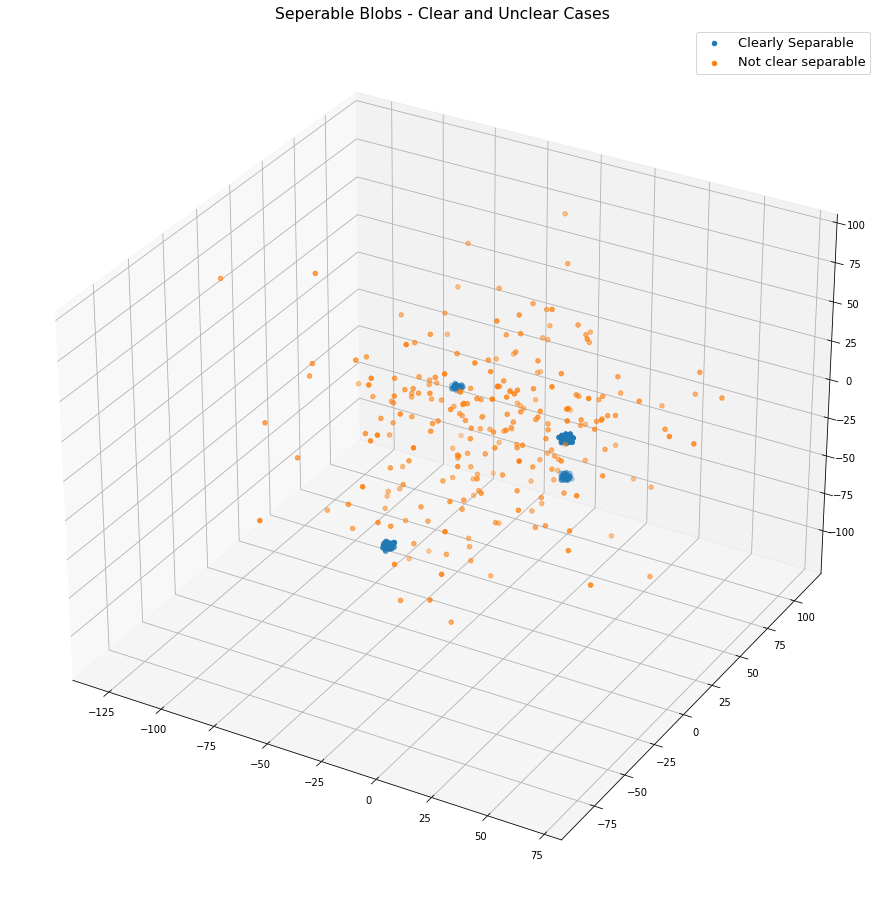

In [4]:
fig = plt.figure(figsize = (16,16))
  
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
plt.rcParams['font.size'] = '13'
ax.scatter3D(cs.X[:, 0], cs.X[:, 1], cs.X[:, 2], label = "Clearly Separable")
ax.scatter3D(uc.X[:, 0], uc.X[:, 1], uc.X[:, 2], label= "Not clear separable")
ax.legend()
plt.title("Seperable Blobs - Clear and Unclear Cases")
plt.show()

<b>Note</b>: The above plot provides a visualization of the surrogate data sets generated. The blue clusters represent clearly separable data while the orange dots are not easily separable. 

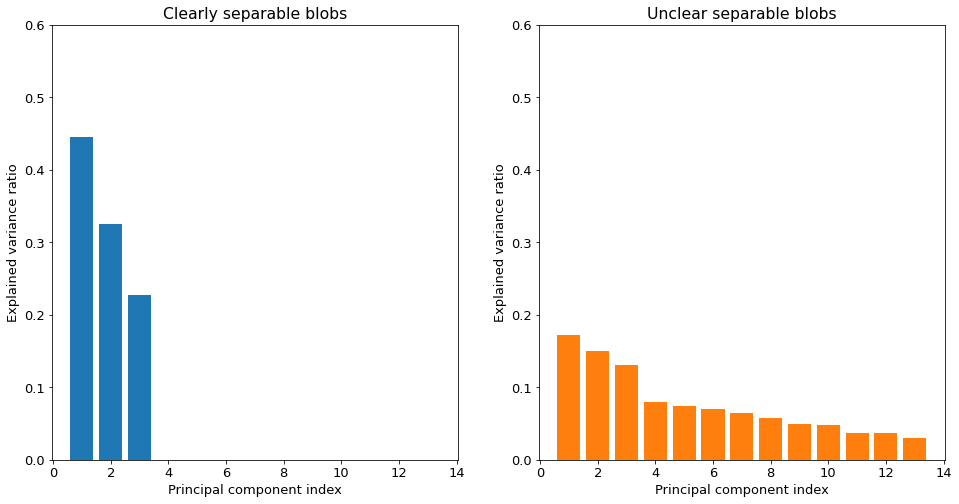

In [5]:
# Plot explained variances
fig, ax = plt.subplots(1,2, figsize = (16,8))
ax[0].bar(range(1,14), cs.var_exp, 
        align='center', label='individual, explained variance', color = "C0")
ax[0].set_ylabel('Explained variance ratio')
ax[0].set_xlabel('Principal component index')
ax[0].set_title("Clearly separable blobs")
ax[0].set_ylim(0,0.6)
ax[1].bar(range(1,14), uc.var_exp, 
        align='center', label='individual, explained variance', color = "C1")
ax[1].set_xlabel('Principal component index')
ax[1].set_ylim(0,0.6)
ax[1].set_ylabel('Explained variance ratio')
ax[1].set_title("Unclear separable blobs")
plt.show()

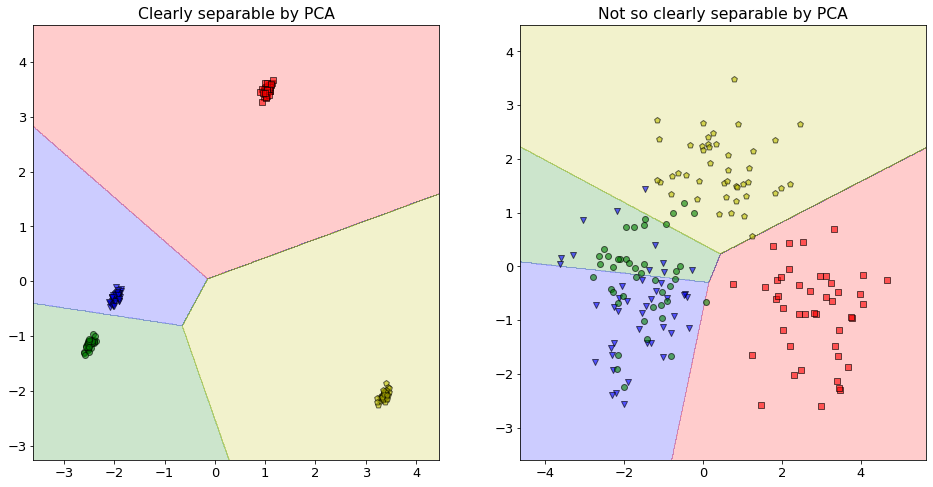

In [6]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
cs.plot_decision_regions()
plt.title("Clearly separable by PCA")

plt.subplot(122)
uc.plot_decision_regions()
plt.title("Not so clearly separable by PCA")
plt.show()

### <h1><center>Question 2a</center></h1>

Under the current parameters, there is a clear separation between classes zero and one, but classes two and three represent a disaster realization and hence overlap significantly. 

<b>Questions for Group</b> <br>
1) He asks us to show the elbow plots as well as the prediction boundary. Does he mean a decision boundary rather than a prediction boundary? I'm not really sure what a prediction boundary would be. <br>
2) Is the takeaway for the elbow charts basically how many features are present and approximately what is the distribution in terms of how much variance each feature explains? <br>
3) I'm thinking the elbow plots should probably come after the classification plots?

In [7]:
cs = Blobs_and_parabolas(parabola = True, n_features = 1)
uc = Blobs_and_parabolas(parabola = True)

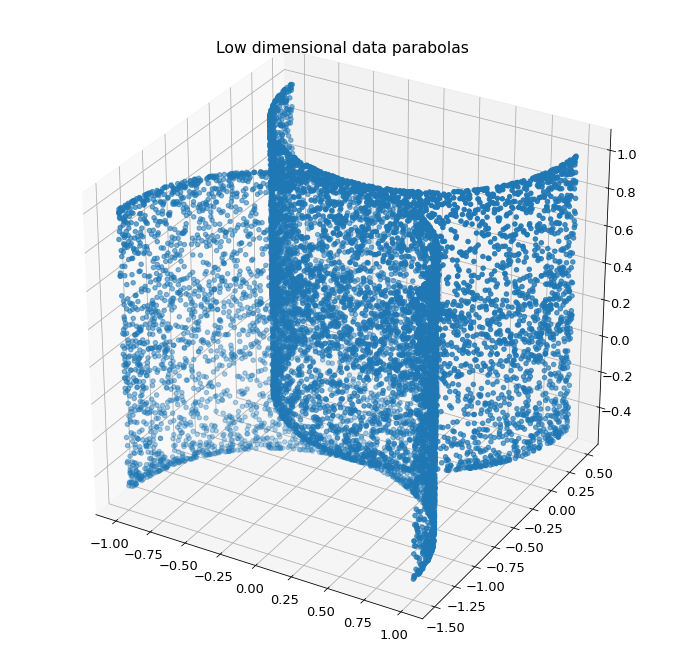

In [8]:
fig = plt.figure(figsize = (12,12))
  
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
ax.scatter3D(cs.X[cs.idx, 0]-1, cs.X[cs.idx, 1], cs.X[cs.idx, 2])
ax.scatter3D(cs.X[~cs.idx, 0], cs.X[~cs.idx, 1]-1.5, cs.X[~cs.idx, 2], color = "C0")
plt.title("Low dimensional data parabolas")
plt.show()

### <h1><center>Question 2b</center></h1>

The parabola spread visualizations show two touching parabolas in three dimensions. One would effect the classifier to have a fairly easy time classifying the data on each side of the two parabolas; the true test of the classifier's efficacy would be how well it classifies the data points at the parabolas' respective vertices.

<u>Note</u>: Response to Question 2b continues below.

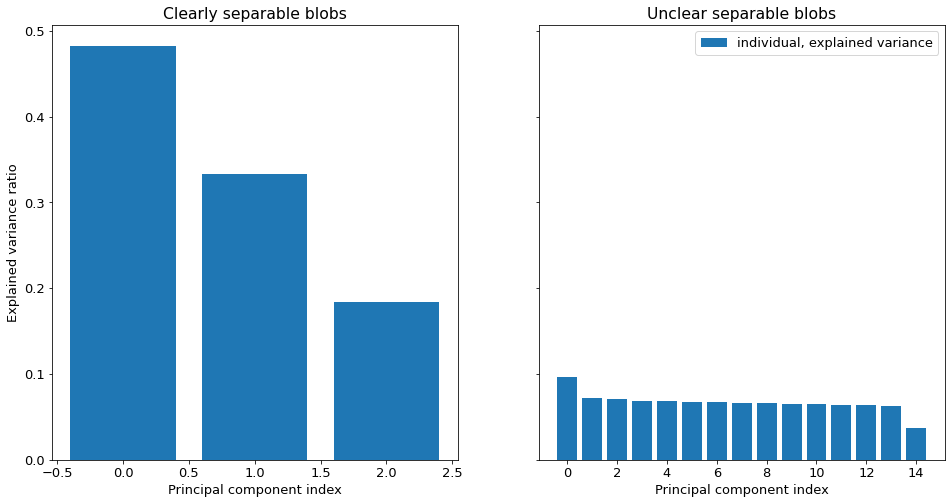

In [9]:
# Plot explained variances
fig, ax = plt.subplots(1,2, figsize = (16,8), sharey = True)
ax[0].bar(range(0,3), cs.var_exp, 
        align='center', label='individual, explained variance')
ax[0].set_ylabel('Explained variance ratio')
ax[0].set_xlabel('Principal component index')
ax[0].set_title("Clearly separable blobs")
ax[1].bar(range(0,15), uc.var_exp, 
        align='center', label='individual, explained variance')
ax[1].set_xlabel('Principal component index')
ax[1].set_title("Unclear separable blobs")
plt.legend(loc='best')
plt.show()

### <h1><center>Question 2b (continued)</center></h1>

The elbow plot for the clearly separable blobs shows there are only three features that explain the variance for these blobs, each one explaining ~15% less variance than the preceeding feature. Conversely, there are 14 features present to explain the variance for the unclearly separable blobs, and while there is some degree of difference in terms of the extent to which these features explain the variance that difference is relatively small; 12 of these features have the same explained variance ratio.

<u>Note</u>: Response to Question 2b continues below.

<b>Questions</b><br>
1) I'm not really clear what the takeaway is here.

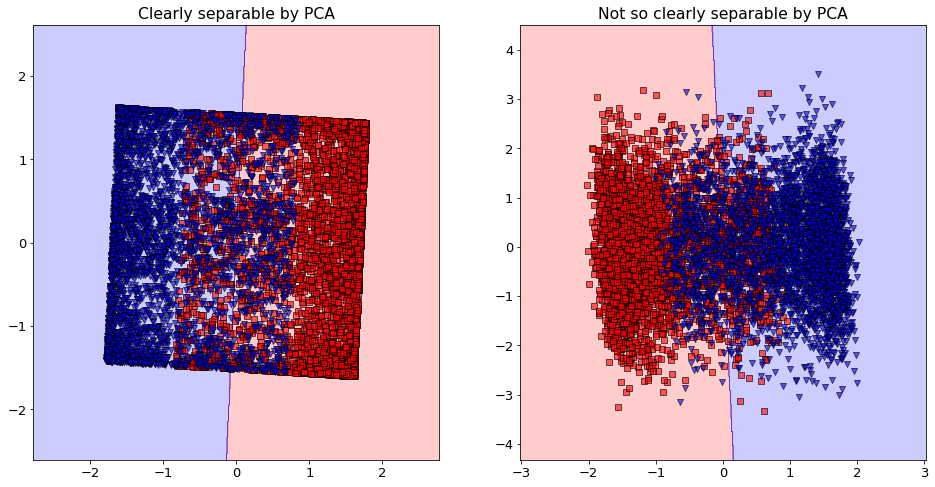

In [10]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
cs.plot_decision_regions()
plt.title("Clearly separable by PCA")

plt.subplot(122)
uc.plot_decision_regions()
plt.title("Not so clearly separable by PCA")
plt.show()

### <h1><center>Question 2b (continued)</center></h1>

Though the two figures above do generally show some degree of separation between the different classes, as a whole it's clear the PCA method does not do an effective job of classifying the clearly separable or not clearly separable surrogate datasets. 

<b>Questions</b><br>
1) Possible reason why this is - PCA doesn't work well when dealing with unstructured data in more than 2 dimensions? 